## Import Library

In [1]:
import os
import json
import warnings
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, f1_score, precision_recall_curve, average_precision_score,
    recall_score,
)
import joblib
from catboost import CatBoostClassifier
from IPython.display import display

import optuna

warnings.filterwarnings('ignore', category=UserWarning)

project_path = "E:/Project/HepatitisC-Prediction/"
file_path = f"{project_path}/Dataset/cleaned_dataset.csv"
result_path = f"{project_path}/Result"
hyper_path = f"{result_path}/Hyperparameter"
model_path = f"{project_path}/Models"

## Load Dataset

In [2]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())

(3687, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3687 non-null   int64  
 1   gender               3687 non-null   int64  
 2   jaundice_history     3687 non-null   int64  
 3   receive_transfusion  3687 non-null   int64  
 4   liver_condition      3687 non-null   int64  
 5   injectable_drug_use  3687 non-null   int64  
 6   drug_use             3687 non-null   int64  
 7   alcohol_consumption  3687 non-null   int64  
 8   alt                  3687 non-null   float64
 9   albumin              3687 non-null   float64
 10  alp                  3687 non-null   float64
 11  ast                  3687 non-null   float64
 12  bun                  3687 non-null   float64
 13  cholesterol          3687 non-null   float64
 14  cpk                  3687 non-null   float64
 15  creatinine           3687 n

## Load Scaler

In [3]:
scaler_existing = joblib.load(f"{model_path}/scaler.joblib")
print(f"Scaler berhasil dimuat")

Scaler berhasil dimuat


In [4]:
df_train = df[df['dataset'] == 'train']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['hcv_status', 'dataset'])
y_train = df_train['hcv_status']

X_test = df_test.drop(columns=['hcv_status', 'dataset'])
y_test = df_test['hcv_status']

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3198, 26)
Test shape: (489, 26)


## Hyperparameter Tuning (5-Fold CV)

In [5]:
class EarlyStoppingCallback:
    def __init__(self, patience=100, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_value = None
        self.trials_without_improvement = 0
    
    def __call__(self, study, trial):
        if self.best_value is None:
            self.best_value = study.best_value
            return
        
        if study.best_value - self.best_value > self.min_delta:
            self.best_value = study.best_value
            self.trials_without_improvement = 0
        else:
            self.trials_without_improvement += 1
        
        if self.trials_without_improvement >= self.patience:
            study.stop()
            print(f"\nEarly stopping triggered! No improvement after {self.patience} trials")
            print(f"Best value: {self.best_value:.4f}")

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    iterations = trial.suggest_int("iterations", 150, 200)  
    learning_rate = trial.suggest_float("learning_rate", 0.03, 0.08)
    depth = trial.suggest_int("depth", 4, 6)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 3, 7)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 15, 20)
    
    model = Pipeline([
        ('scaler', scaler_existing),
        ('classifier', CatBoostClassifier(
            iterations=iterations,
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            min_data_in_leaf=min_data_in_leaf,
            verbose=False,
            loss_function="Logloss",
            allow_writing_files=False,
            random_state=42,
        ))
    ])

    train_acc_list = []
    val_acc_list = []
    val_recall_list = []

    for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_t, y_t)

        train_pred = model.predict(X_t)
        train_acc = accuracy_score(y_t, train_pred)
        train_acc_list.append(train_acc)

        val_pred = model.predict(X_v)
        val_acc = accuracy_score(y_v, val_pred)
        val_recall = recall_score(y_v, val_pred, average="macro")

        val_acc_list.append(val_acc)
        val_recall_list.append(val_recall)
        
        intermediate_recall = np.mean(val_recall_list)
        trial.report(intermediate_recall, fold_idx)
        
        # Handle pruning - skip trial jika performa buruk
        if trial.should_prune():
            raise optuna.TrialPruned()

    mean_train_acc = np.mean(train_acc_list)
    mean_val_acc = np.mean(val_acc_list)
    mean_val_recall = np.mean(val_recall_list)

    print(f"Trial {trial.number}: "
          f"Train Acc = {mean_train_acc:.4f}, "
          f"Val Acc = {mean_val_acc:.4f}, "
          f"Val Recall = {mean_val_recall:.4f}")

    return mean_val_recall

In [15]:
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=10,  # Tunggu 10 trial pertama sebelum mulai prune
        n_warmup_steps=2,  # Tunggu 2 fold sebelum mulai prune
        interval_steps=1,  # Check setiap fold
    ),
    sampler=optuna.samplers.TPESampler(seed=42)
)

early_stopping = EarlyStoppingCallback(patience=100, min_delta=0.0001)
study.optimize(objective, n_trials=1000, callbacks=[early_stopping])

print("\n" + "=" * 60)
print("Tuning Selesai!")
print("=" * 60)
print(f"Total trials: {len(study.trials)}")
print(
    f"Total trials pruned: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}"
)
print(
    f"Total trials berhasil: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}"
)

[I 2025-12-13 20:44:55,385] A new study created in memory with name: no-name-0c4ee163-62cf-46fb-9a26-f73a21a24c7d
[I 2025-12-13 20:44:57,451] Trial 0 finished with value: 0.9734139890282132 and parameters: {'iterations': 169, 'learning_rate': 0.0775357153204958, 'depth': 6, 'l2_leaf_reg': 5, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9734139890282132.


Trial 0: Train Acc = 0.9987, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-13 20:44:59,310] Trial 1 finished with value: 0.9671610501567398 and parameters: {'iterations': 157, 'learning_rate': 0.03290418060840997, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.9734139890282132.


Trial 1: Train Acc = 0.9901, Val Acc = 0.9672, Val Recall = 0.9672


[I 2025-12-13 20:45:01,235] Trial 2 finished with value: 0.9743573667711599 and parameters: {'iterations': 151, 'learning_rate': 0.07849549260809971, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.9743573667711599.


Trial 2: Train Acc = 0.9985, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:45:02,727] Trial 3 finished with value: 0.9696610501567399 and parameters: {'iterations': 159, 'learning_rate': 0.045212112147976886, 'depth': 5, 'l2_leaf_reg': 5, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.9743573667711599.


Trial 3: Train Acc = 0.9904, Val Acc = 0.9697, Val Recall = 0.9697


[I 2025-12-13 20:45:04,157] Trial 4 finished with value: 0.9662245297805642 and parameters: {'iterations': 181, 'learning_rate': 0.03697469303260209, 'depth': 4, 'l2_leaf_reg': 4, 'min_data_in_leaf': 17}. Best is trial 2 with value: 0.9743573667711599.


Trial 4: Train Acc = 0.9838, Val Acc = 0.9662, Val Recall = 0.9662


[I 2025-12-13 20:45:05,913] Trial 5 finished with value: 0.9712264890282132 and parameters: {'iterations': 190, 'learning_rate': 0.03998368910791798, 'depth': 5, 'l2_leaf_reg': 5, 'min_data_in_leaf': 15}. Best is trial 2 with value: 0.9743573667711599.


Trial 5: Train Acc = 0.9911, Val Acc = 0.9712, Val Recall = 0.9712


[I 2025-12-13 20:45:07,327] Trial 6 finished with value: 0.9668495297805642 and parameters: {'iterations': 180, 'learning_rate': 0.03852620618436457, 'depth': 4, 'l2_leaf_reg': 7, 'min_data_in_leaf': 20}. Best is trial 2 with value: 0.9743573667711599.


Trial 6: Train Acc = 0.9826, Val Acc = 0.9668, Val Recall = 0.9668


[I 2025-12-13 20:45:08,886] Trial 7 finished with value: 0.9681005094043889 and parameters: {'iterations': 191, 'learning_rate': 0.04523068845866853, 'depth': 4, 'l2_leaf_reg': 6, 'min_data_in_leaf': 17}. Best is trial 2 with value: 0.9743573667711599.


Trial 7: Train Acc = 0.9870, Val Acc = 0.9681, Val Recall = 0.9681


[I 2025-12-13 20:45:10,132] Trial 8 finished with value: 0.9668514890282133 and parameters: {'iterations': 156, 'learning_rate': 0.05475884550556351, 'depth': 4, 'l2_leaf_reg': 7, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.9743573667711599.


Trial 8: Train Acc = 0.9855, Val Acc = 0.9668, Val Recall = 0.9669


[I 2025-12-13 20:45:11,868] Trial 9 finished with value: 0.9721659482758621 and parameters: {'iterations': 183, 'learning_rate': 0.04558555380447055, 'depth': 5, 'l2_leaf_reg': 5, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.9743573667711599.


Trial 9: Train Acc = 0.9930, Val Acc = 0.9722, Val Recall = 0.9722


[I 2025-12-13 20:45:13,937] Trial 10 finished with value: 0.974667907523511 and parameters: {'iterations': 169, 'learning_rate': 0.07663576416884421, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 10 with value: 0.974667907523511.


Trial 10: Train Acc = 0.9995, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:45:16,021] Trial 11 finished with value: 0.9765399686520377 and parameters: {'iterations': 167, 'learning_rate': 0.07922201645123057, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.9765399686520377.


Trial 11: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:45:18,055] Trial 12 finished with value: 0.9740409482758621 and parameters: {'iterations': 167, 'learning_rate': 0.06878591856443672, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.9765399686520377.


Trial 12: Train Acc = 0.9991, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-13 20:45:20,116] Trial 13 finished with value: 0.9746669278996866 and parameters: {'iterations': 169, 'learning_rate': 0.0644945211674846, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 11 with value: 0.9765399686520377.


Trial 13: Train Acc = 0.9988, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:45:22,108] Trial 14 finished with value: 0.9749794278996864 and parameters: {'iterations': 164, 'learning_rate': 0.06954178991106393, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 11 with value: 0.9765399686520377.


Trial 14: Train Acc = 0.9989, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 20:45:24,029] Trial 15 finished with value: 0.9749764890282131 and parameters: {'iterations': 199, 'learning_rate': 0.06859647918800968, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.9765399686520377.


Trial 15: Train Acc = 0.9970, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 20:45:26,001] Trial 16 finished with value: 0.9771698667711599 and parameters: {'iterations': 163, 'learning_rate': 0.05927501303908393, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 16: Train Acc = 0.9981, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 20:45:27,673] Trial 17 finished with value: 0.9734130094043886 and parameters: {'iterations': 174, 'learning_rate': 0.05730251035808605, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 17: Train Acc = 0.9942, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-13 20:45:29,699] Trial 18 finished with value: 0.9765438871473355 and parameters: {'iterations': 163, 'learning_rate': 0.057667913057818876, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 18: Train Acc = 0.9980, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:45:31,160] Trial 19 finished with value: 0.9727909482758621 and parameters: {'iterations': 151, 'learning_rate': 0.057936741251622535, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 19: Train Acc = 0.9937, Val Acc = 0.9728, Val Recall = 0.9728


[I 2025-12-13 20:45:33,122] Trial 20 finished with value: 0.9743524686520377 and parameters: {'iterations': 161, 'learning_rate': 0.053208324802247575, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 20: Train Acc = 0.9970, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:45:35,262] Trial 21 finished with value: 0.9746630094043887 and parameters: {'iterations': 174, 'learning_rate': 0.051180291626487844, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 21: Train Acc = 0.9973, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:45:37,242] Trial 22 finished with value: 0.9743514890282132 and parameters: {'iterations': 163, 'learning_rate': 0.06253003335404285, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 22: Train Acc = 0.9983, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:45:39,285] Trial 23 finished with value: 0.9749784482758621 and parameters: {'iterations': 164, 'learning_rate': 0.0629001741352533, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 23: Train Acc = 0.9977, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 20:45:41,201] Trial 24 finished with value: 0.9743544278996866 and parameters: {'iterations': 156, 'learning_rate': 0.07263483175866843, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 24: Train Acc = 0.9991, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:45:43,396] Trial 25 finished with value: 0.9746669278996866 and parameters: {'iterations': 176, 'learning_rate': 0.06020792747505997, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 25: Train Acc = 0.9976, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:45:44,419] Trial 26 pruned. 
[I 2025-12-13 20:45:46,491] Trial 27 finished with value: 0.975605407523511 and parameters: {'iterations': 167, 'learning_rate': 0.07369721087977876, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 27: Train Acc = 0.9981, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:45:47,535] Trial 28 pruned. 
[I 2025-12-13 20:45:49,721] Trial 29 finished with value: 0.9734139890282132 and parameters: {'iterations': 161, 'learning_rate': 0.06671955332946602, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 29: Train Acc = 0.9986, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-13 20:45:51,849] Trial 30 finished with value: 0.975603448275862 and parameters: {'iterations': 171, 'learning_rate': 0.07385120515287857, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 30: Train Acc = 0.9991, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:45:53,922] Trial 31 finished with value: 0.9749784482758621 and parameters: {'iterations': 166, 'learning_rate': 0.07463457776721215, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 31: Train Acc = 0.9979, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 20:45:55,979] Trial 32 finished with value: 0.9743544278996866 and parameters: {'iterations': 167, 'learning_rate': 0.07947306277660576, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 32: Train Acc = 0.9981, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:45:57,153] Trial 33 pruned. 
[I 2025-12-13 20:45:59,086] Trial 34 finished with value: 0.9743524686520377 and parameters: {'iterations': 161, 'learning_rate': 0.07574931324443732, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 34: Train Acc = 0.9973, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:46:01,253] Trial 35 finished with value: 0.9746649686520377 and parameters: {'iterations': 177, 'learning_rate': 0.0597365594923262, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 35: Train Acc = 0.9965, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:46:02,500] Trial 36 pruned. 
[I 2025-12-13 20:46:03,980] Trial 37 finished with value: 0.9752929075235108 and parameters: {'iterations': 154, 'learning_rate': 0.0652953832735548, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 37: Train Acc = 0.9951, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:46:05,225] Trial 38 pruned. 
[I 2025-12-13 20:46:07,158] Trial 39 finished with value: 0.9718514890282132 and parameters: {'iterations': 159, 'learning_rate': 0.04232531159106497, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 39: Train Acc = 0.9937, Val Acc = 0.9719, Val Recall = 0.9719


[I 2025-12-13 20:46:08,491] Trial 40 pruned. 
[I 2025-12-13 20:46:10,580] Trial 41 finished with value: 0.9759159482758621 and parameters: {'iterations': 172, 'learning_rate': 0.07322853199483642, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 41: Train Acc = 0.9991, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:46:12,661] Trial 42 finished with value: 0.974980407523511 and parameters: {'iterations': 172, 'learning_rate': 0.07084934122193046, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.9771698667711599.


Trial 42: Train Acc = 0.9988, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 20:46:14,657] Trial 43 finished with value: 0.976540948275862 and parameters: {'iterations': 166, 'learning_rate': 0.07797760949454847, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 43: Train Acc = 0.9995, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:46:15,496] Trial 44 pruned. 
[I 2025-12-13 20:46:17,527] Trial 45 finished with value: 0.9762274686520376 and parameters: {'iterations': 167, 'learning_rate': 0.07957269463121021, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 45: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:46:18,676] Trial 46 pruned. 
[I 2025-12-13 20:46:20,938] Trial 47 finished with value: 0.9743524686520375 and parameters: {'iterations': 185, 'learning_rate': 0.0559359978569621, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 47: Train Acc = 0.9985, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:46:22,559] Trial 48 finished with value: 0.9743544278996865 and parameters: {'iterations': 169, 'learning_rate': 0.07960869512840231, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.9771698667711599.


Trial 48: Train Acc = 0.9977, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:46:24,583] Trial 49 finished with value: 0.9743524686520375 and parameters: {'iterations': 167, 'learning_rate': 0.05371156594685859, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 49: Train Acc = 0.9977, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:46:26,607] Trial 50 finished with value: 0.9746649686520377 and parameters: {'iterations': 164, 'learning_rate': 0.06697023092865308, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 50: Train Acc = 0.9989, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:46:27,864] Trial 51 pruned. 
[I 2025-12-13 20:46:29,916] Trial 52 finished with value: 0.9762304075235111 and parameters: {'iterations': 169, 'learning_rate': 0.07856695426495706, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 52: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:46:31,936] Trial 53 finished with value: 0.9765438871473353 and parameters: {'iterations': 166, 'learning_rate': 0.07821776454375924, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 53: Train Acc = 0.9997, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:46:33,175] Trial 54 pruned. 
[I 2025-12-13 20:46:35,138] Trial 55 finished with value: 0.9759149686520378 and parameters: {'iterations': 163, 'learning_rate': 0.07019903342032709, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 55: Train Acc = 0.9991, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:46:36,374] Trial 56 pruned. 
[I 2025-12-13 20:46:37,311] Trial 57 pruned. 
[I 2025-12-13 20:46:38,593] Trial 58 pruned. 
[I 2025-12-13 20:46:40,516] Trial 59 finished with value: 0.9737294278996865 and parameters: {'iterations': 157, 'learning_rate': 0.06839991231457557, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 59: Train Acc = 0.9978, Val Acc = 0.9737, Val Recall = 0.9737


[I 2025-12-13 20:46:41,463] Trial 60 pruned. 
[I 2025-12-13 20:46:43,537] Trial 61 finished with value: 0.9752909482758622 and parameters: {'iterations': 168, 'learning_rate': 0.07977312412405896, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 61: Train Acc = 0.9998, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:46:44,760] Trial 62 pruned. 
[I 2025-12-13 20:46:46,883] Trial 63 finished with value: 0.9752899686520375 and parameters: {'iterations': 163, 'learning_rate': 0.07165772871314233, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 63: Train Acc = 0.9990, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:46:48,242] Trial 64 pruned. 
[I 2025-12-13 20:46:49,477] Trial 65 pruned. 
[I 2025-12-13 20:46:51,480] Trial 66 finished with value: 0.9743495297805641 and parameters: {'iterations': 162, 'learning_rate': 0.05138861406780258, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.9771698667711599.


Trial 66: Train Acc = 0.9959, Val Acc = 0.9744, Val Recall = 0.9743


[I 2025-12-13 20:46:53,510] Trial 67 finished with value: 0.9746639890282133 and parameters: {'iterations': 168, 'learning_rate': 0.04722566040296969, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 16}. Best is trial 16 with value: 0.9771698667711599.


Trial 67: Train Acc = 0.9962, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:46:55,582] Trial 68 finished with value: 0.9765448667711599 and parameters: {'iterations': 171, 'learning_rate': 0.0727813467298607, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 68: Train Acc = 0.9997, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:46:56,844] Trial 69 pruned. 
[I 2025-12-13 20:46:57,893] Trial 70 pruned. 
[I 2025-12-13 20:46:59,927] Trial 71 finished with value: 0.9768563871473355 and parameters: {'iterations': 166, 'learning_rate': 0.07821050756248236, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 71: Train Acc = 0.9996, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:47:02,065] Trial 72 finished with value: 0.9752909482758622 and parameters: {'iterations': 174, 'learning_rate': 0.07779358940819299, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 72: Train Acc = 0.9997, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:47:04,097] Trial 73 finished with value: 0.976228448275862 and parameters: {'iterations': 165, 'learning_rate': 0.056272688721177036, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 73: Train Acc = 0.9974, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:47:05,386] Trial 74 pruned. 
[I 2025-12-13 20:47:06,830] Trial 75 pruned. 
[I 2025-12-13 20:47:08,812] Trial 76 finished with value: 0.9762304075235111 and parameters: {'iterations': 162, 'learning_rate': 0.07836540722574845, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 76: Train Acc = 0.9995, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:47:10,982] Trial 77 finished with value: 0.9762294278996866 and parameters: {'iterations': 179, 'learning_rate': 0.07532130363690714, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 77: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:47:12,164] Trial 78 pruned. 
[I 2025-12-13 20:47:14,244] Trial 79 finished with value: 0.9762284482758622 and parameters: {'iterations': 168, 'learning_rate': 0.07980121462264254, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 79: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:47:15,588] Trial 80 pruned. 
[I 2025-12-13 20:47:17,797] Trial 81 finished with value: 0.9762304075235109 and parameters: {'iterations': 166, 'learning_rate': 0.07824453979667692, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 81: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:47:19,827] Trial 82 finished with value: 0.9771688871473355 and parameters: {'iterations': 162, 'learning_rate': 0.07842910165202477, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 82: Train Acc = 0.9995, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 20:47:21,773] Trial 83 finished with value: 0.9743524686520375 and parameters: {'iterations': 155, 'learning_rate': 0.07455579304824209, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 83: Train Acc = 0.9993, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:47:22,959] Trial 84 pruned. 
[I 2025-12-13 20:47:24,296] Trial 85 pruned. 
[I 2025-12-13 20:47:26,430] Trial 86 finished with value: 0.975603448275862 and parameters: {'iterations': 163, 'learning_rate': 0.07999210752074147, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 16 with value: 0.9771698667711599.


Trial 86: Train Acc = 0.9996, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:47:28,463] Trial 87 finished with value: 0.976228448275862 and parameters: {'iterations': 166, 'learning_rate': 0.07183634481336564, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 87: Train Acc = 0.9995, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:47:30,517] Trial 88 finished with value: 0.9752919278996866 and parameters: {'iterations': 168, 'learning_rate': 0.07869641030139947, 'depth': 6, 'l2_leaf_reg': 4, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 88: Train Acc = 0.9991, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:47:32,579] Trial 89 finished with value: 0.9756044278996866 and parameters: {'iterations': 158, 'learning_rate': 0.05879788000655606, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9771698667711599.


Trial 89: Train Acc = 0.9978, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:47:33,947] Trial 90 pruned. 
[I 2025-12-13 20:47:36,168] Trial 91 finished with value: 0.975917907523511 and parameters: {'iterations': 162, 'learning_rate': 0.07853111314031075, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 91: Train Acc = 0.9996, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:47:37,485] Trial 92 pruned. 
[I 2025-12-13 20:47:39,619] Trial 93 finished with value: 0.9746649686520374 and parameters: {'iterations': 167, 'learning_rate': 0.07409297026563218, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 93: Train Acc = 0.9995, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-13 20:47:41,581] Trial 94 finished with value: 0.9749784482758621 and parameters: {'iterations': 162, 'learning_rate': 0.07557950759363358, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 16 with value: 0.9771698667711599.


Trial 94: Train Acc = 0.9995, Val Acc = 0.9750, Val Recall = 0.9750


[I 2025-12-13 20:47:42,876] Trial 95 pruned. 
[I 2025-12-13 20:47:44,106] Trial 96 pruned. 
[I 2025-12-13 20:47:45,436] Trial 97 pruned. 
[I 2025-12-13 20:47:47,615] Trial 98 finished with value: 0.9743544278996865 and parameters: {'iterations': 164, 'learning_rate': 0.070394339481418, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9771698667711599.


Trial 98: Train Acc = 0.9990, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:47:48,872] Trial 99 pruned. 
[I 2025-12-13 20:47:50,123] Trial 100 pruned. 
[I 2025-12-13 20:47:52,123] Trial 101 finished with value: 0.9774813871473353 and parameters: {'iterations': 166, 'learning_rate': 0.07841210222601117, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 101 with value: 0.9774813871473353.


Trial 101: Train Acc = 0.9996, Val Acc = 0.9775, Val Recall = 0.9775


[I 2025-12-13 20:47:53,352] Trial 102 pruned. 
[I 2025-12-13 20:47:55,403] Trial 103 finished with value: 0.9762313871473355 and parameters: {'iterations': 169, 'learning_rate': 0.07857084017009033, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20}. Best is trial 101 with value: 0.9774813871473353.


Trial 103: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:47:56,631] Trial 104 pruned. 
[I 2025-12-13 20:47:57,931] Trial 105 pruned. 
[I 2025-12-13 20:47:59,177] Trial 106 pruned. 
[I 2025-12-13 20:48:01,235] Trial 107 finished with value: 0.9756044278996866 and parameters: {'iterations': 171, 'learning_rate': 0.06907186772468943, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 107: Train Acc = 0.9991, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:48:02,459] Trial 108 pruned. 
[I 2025-12-13 20:48:03,698] Trial 109 pruned. 
[I 2025-12-13 20:48:04,933] Trial 110 pruned. 
[I 2025-12-13 20:48:06,148] Trial 111 pruned. 
[I 2025-12-13 20:48:07,367] Trial 112 pruned. 
[I 2025-12-13 20:48:08,581] Trial 113 pruned. 
[I 2025-12-13 20:48:09,796] Trial 114 pruned. 
[I 2025-12-13 20:48:11,062] Trial 115 pruned. 
[I 2025-12-13 20:48:13,033] Trial 116 finished with value: 0.9771698667711599 and parameters: {'iterations': 159, 'learning_rate': 0.07275492277257588, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 101 with value: 0.9774813871473353.


Trial 116: Train Acc = 0.9994, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 20:48:13,824] Trial 117 pruned. 
[I 2025-12-13 20:48:14,944] Trial 118 pruned. 
[I 2025-12-13 20:48:16,216] Trial 119 pruned. 
[I 2025-12-13 20:48:18,261] Trial 120 finished with value: 0.9759149686520378 and parameters: {'iterations': 159, 'learning_rate': 0.05955724838463438, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 120: Train Acc = 0.9980, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:48:20,348] Trial 121 finished with value: 0.9768563871473355 and parameters: {'iterations': 157, 'learning_rate': 0.07676341933371052, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 101 with value: 0.9774813871473353.


Trial 121: Train Acc = 0.9992, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:48:21,623] Trial 122 pruned. 
[I 2025-12-13 20:48:22,886] Trial 123 pruned. 
[I 2025-12-13 20:48:24,959] Trial 124 finished with value: 0.9752899686520375 and parameters: {'iterations': 156, 'learning_rate': 0.07550240139130948, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 101 with value: 0.9774813871473353.


Trial 124: Train Acc = 0.9991, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:48:26,101] Trial 125 pruned. 
[I 2025-12-13 20:48:28,441] Trial 126 finished with value: 0.9765419278996864 and parameters: {'iterations': 170, 'learning_rate': 0.07782140365519477, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 126: Train Acc = 0.9997, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:48:29,796] Trial 127 pruned. 
[I 2025-12-13 20:48:31,861] Trial 128 finished with value: 0.9774804075235108 and parameters: {'iterations': 170, 'learning_rate': 0.07995217065418227, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 128: Train Acc = 0.9999, Val Acc = 0.9775, Val Recall = 0.9775


[I 2025-12-13 20:48:34,011] Trial 129 finished with value: 0.9752909482758622 and parameters: {'iterations': 173, 'learning_rate': 0.07759384432189702, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 129: Train Acc = 0.9998, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:48:36,138] Trial 130 finished with value: 0.9768563871473355 and parameters: {'iterations': 175, 'learning_rate': 0.07533288216811196, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 130: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:48:38,317] Trial 131 finished with value: 0.9768544278996865 and parameters: {'iterations': 174, 'learning_rate': 0.07984998466010997, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 131: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:48:39,646] Trial 132 pruned. 
[I 2025-12-13 20:48:41,749] Trial 133 finished with value: 0.9771679075235109 and parameters: {'iterations': 175, 'learning_rate': 0.07994574836462308, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 133: Train Acc = 0.9999, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 20:48:43,042] Trial 134 pruned. 
[I 2025-12-13 20:48:45,196] Trial 135 finished with value: 0.9752889890282133 and parameters: {'iterations': 176, 'learning_rate': 0.07960295131700967, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 135: Train Acc = 0.9998, Val Acc = 0.9753, Val Recall = 0.9753


[I 2025-12-13 20:48:46,528] Trial 136 pruned. 
[I 2025-12-13 20:48:47,816] Trial 137 pruned. 
[I 2025-12-13 20:48:50,012] Trial 138 finished with value: 0.9765438871473353 and parameters: {'iterations': 179, 'learning_rate': 0.07275608684117503, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 138: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:48:51,334] Trial 139 pruned. 
[I 2025-12-13 20:48:52,641] Trial 140 pruned. 
[I 2025-12-13 20:48:54,027] Trial 141 pruned. 
[I 2025-12-13 20:48:55,317] Trial 142 pruned. 
[I 2025-12-13 20:48:56,576] Trial 143 pruned. 
[I 2025-12-13 20:48:57,861] Trial 144 pruned. 
[I 2025-12-13 20:48:59,174] Trial 145 pruned. 
[I 2025-12-13 20:49:00,472] Trial 146 pruned. 
[I 2025-12-13 20:49:02,536] Trial 147 finished with value: 0.9774794278996864 and parameters: {'iterations': 172, 'learning_rate': 0.07995357281032224, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 147: Train Acc = 0.9999, Val Acc = 0.9775, Val Recall = 0.9775


[I 2025-12-13 20:49:03,547] Trial 148 pruned. 
[I 2025-12-13 20:49:04,846] Trial 149 pruned. 
[I 2025-12-13 20:49:06,153] Trial 150 pruned. 
[I 2025-12-13 20:49:07,426] Trial 151 pruned. 
[I 2025-12-13 20:49:09,544] Trial 152 finished with value: 0.9762294278996866 and parameters: {'iterations': 173, 'learning_rate': 0.07805624765351035, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 152: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:49:10,879] Trial 153 pruned. 
[I 2025-12-13 20:49:13,012] Trial 154 finished with value: 0.9768544278996865 and parameters: {'iterations': 170, 'learning_rate': 0.07997437590830783, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 154: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:49:15,180] Trial 155 finished with value: 0.9774794278996864 and parameters: {'iterations': 171, 'learning_rate': 0.07995185217470145, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 155: Train Acc = 0.9999, Val Acc = 0.9775, Val Recall = 0.9775


[I 2025-12-13 20:49:17,331] Trial 156 finished with value: 0.9759159482758621 and parameters: {'iterations': 172, 'learning_rate': 0.0791767515683371, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 156: Train Acc = 0.9997, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:49:18,577] Trial 157 pruned. 
[I 2025-12-13 20:49:20,687] Trial 158 finished with value: 0.9765438871473353 and parameters: {'iterations': 174, 'learning_rate': 0.07836727608507399, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 101 with value: 0.9774813871473353.


Trial 158: Train Acc = 1.0000, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:49:22,727] Trial 159 finished with value: 0.9771669278996866 and parameters: {'iterations': 171, 'learning_rate': 0.07996941546076003, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 159: Train Acc = 0.9998, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 20:49:24,851] Trial 160 finished with value: 0.9768524686520376 and parameters: {'iterations': 171, 'learning_rate': 0.07921950277885748, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 160: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:49:26,959] Trial 161 finished with value: 0.9768534482758622 and parameters: {'iterations': 171, 'learning_rate': 0.07996657822539045, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 161: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:49:29,198] Trial 162 finished with value: 0.9765419278996866 and parameters: {'iterations': 171, 'learning_rate': 0.07982948396239614, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 162: Train Acc = 0.9999, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:49:30,580] Trial 163 pruned. 
[I 2025-12-13 20:49:32,796] Trial 164 finished with value: 0.9762294278996866 and parameters: {'iterations': 171, 'learning_rate': 0.07735580583351104, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 164: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:49:35,024] Trial 165 finished with value: 0.9768544278996865 and parameters: {'iterations': 173, 'learning_rate': 0.07986191109694771, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 165: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:49:37,336] Trial 166 finished with value: 0.9759159482758621 and parameters: {'iterations': 173, 'learning_rate': 0.07889409271466687, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 101 with value: 0.9774813871473353.


Trial 166: Train Acc = 0.9997, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:49:39,590] Trial 167 finished with value: 0.9777929075235111 and parameters: {'iterations': 175, 'learning_rate': 0.07924366730175401, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 167: Train Acc = 0.9998, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 20:49:40,982] Trial 168 pruned. 
[I 2025-12-13 20:49:43,188] Trial 169 finished with value: 0.976540948275862 and parameters: {'iterations': 174, 'learning_rate': 0.07997374059218873, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 169: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:49:44,502] Trial 170 pruned. 
[I 2025-12-13 20:49:45,929] Trial 171 pruned. 
[I 2025-12-13 20:49:48,173] Trial 172 finished with value: 0.9765419278996866 and parameters: {'iterations': 170, 'learning_rate': 0.07983161266500677, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 172: Train Acc = 0.9999, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:49:50,406] Trial 173 finished with value: 0.9768563871473355 and parameters: {'iterations': 172, 'learning_rate': 0.07836493824639872, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 173: Train Acc = 0.9999, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:49:51,815] Trial 174 pruned. 
[I 2025-12-13 20:49:53,290] Trial 175 pruned. 
[I 2025-12-13 20:49:54,695] Trial 176 pruned. 
[I 2025-12-13 20:49:57,047] Trial 177 finished with value: 0.9762294278996866 and parameters: {'iterations': 175, 'learning_rate': 0.07993201821971418, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 177: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:49:58,399] Trial 178 pruned. 
[I 2025-12-13 20:49:59,710] Trial 179 pruned. 
[I 2025-12-13 20:50:00,587] Trial 180 pruned. 
[I 2025-12-13 20:50:02,721] Trial 181 finished with value: 0.9768524686520376 and parameters: {'iterations': 174, 'learning_rate': 0.07921989670126833, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 181: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:50:04,819] Trial 182 finished with value: 0.9771679075235109 and parameters: {'iterations': 171, 'learning_rate': 0.07858114814282215, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 182: Train Acc = 0.9996, Val Acc = 0.9772, Val Recall = 0.9772


[I 2025-12-13 20:50:06,741] Trial 183 finished with value: 0.975603448275862 and parameters: {'iterations': 156, 'learning_rate': 0.079979800162903, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 183: Train Acc = 0.9995, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:50:08,004] Trial 184 pruned. 
[I 2025-12-13 20:50:09,286] Trial 185 pruned. 
[I 2025-12-13 20:50:10,577] Trial 186 pruned. 
[I 2025-12-13 20:50:11,822] Trial 187 pruned. 
[I 2025-12-13 20:50:13,910] Trial 188 finished with value: 0.9765419278996864 and parameters: {'iterations': 171, 'learning_rate': 0.07998237354950849, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 188: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:50:15,176] Trial 189 pruned. 
[I 2025-12-13 20:50:16,608] Trial 190 pruned. 
[I 2025-12-13 20:50:17,877] Trial 191 pruned. 
[I 2025-12-13 20:50:19,989] Trial 192 finished with value: 0.9762294278996866 and parameters: {'iterations': 172, 'learning_rate': 0.07882527776474302, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 192: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:50:22,171] Trial 193 finished with value: 0.975603448275862 and parameters: {'iterations': 168, 'learning_rate': 0.07766106499686647, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 193: Train Acc = 0.9996, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:50:23,478] Trial 194 pruned. 
[I 2025-12-13 20:50:25,599] Trial 195 finished with value: 0.975603448275862 and parameters: {'iterations': 171, 'learning_rate': 0.07935732412755517, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 195: Train Acc = 0.9999, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:50:26,883] Trial 196 pruned. 
[I 2025-12-13 20:50:28,171] Trial 197 pruned. 
[I 2025-12-13 20:50:29,412] Trial 198 pruned. 
[I 2025-12-13 20:50:30,730] Trial 199 pruned. 
[I 2025-12-13 20:50:32,129] Trial 200 pruned. 
[I 2025-12-13 20:50:33,632] Trial 201 pruned. 
[I 2025-12-13 20:50:35,947] Trial 202 finished with value: 0.9743514890282132 and parameters: {'iterations': 172, 'learning_rate': 0.04983827509904026, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 202: Train Acc = 0.9967, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-13 20:50:37,253] Trial 203 pruned. 
[I 2025-12-13 20:50:38,448] Trial 204 pruned. 
[I 2025-12-13 20:50:39,726] Trial 205 pruned. 
[I 2025-12-13 20:50:41,260] Trial 206 pruned. 
[I 2025-12-13 20:50:42,745] Trial 207 pruned. 
[I 2025-12-13 20:50:44,161] Trial 208 pruned. 
[I 2025-12-13 20:50:46,660] Trial 209 finished with value: 0.9765419278996864 and parameters: {'iterations': 175, 'learning_rate': 0.07998951871417485, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 209: Train Acc = 0.9999, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:50:48,017] Trial 210 pruned. 
[I 2025-12-13 20:50:50,172] Trial 211 finished with value: 0.97748236677116 and parameters: {'iterations': 171, 'learning_rate': 0.07864729643719533, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 211: Train Acc = 0.9995, Val Acc = 0.9775, Val Recall = 0.9775


[I 2025-12-13 20:50:51,473] Trial 212 pruned. 
[I 2025-12-13 20:50:53,416] Trial 213 finished with value: 0.9768534482758622 and parameters: {'iterations': 157, 'learning_rate': 0.07797737086557989, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 213: Train Acc = 0.9993, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:50:55,364] Trial 214 finished with value: 0.9768554075235109 and parameters: {'iterations': 157, 'learning_rate': 0.07798676403698061, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 214: Train Acc = 0.9992, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:50:56,579] Trial 215 pruned. 
[I 2025-12-13 20:50:57,780] Trial 216 pruned. 
[I 2025-12-13 20:50:59,700] Trial 217 finished with value: 0.9759169278996864 and parameters: {'iterations': 155, 'learning_rate': 0.07726204779376435, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 217: Train Acc = 0.9994, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:00,857] Trial 218 pruned. 
[I 2025-12-13 20:51:02,056] Trial 219 pruned. 
[I 2025-12-13 20:51:03,240] Trial 220 pruned. 
[I 2025-12-13 20:51:04,399] Trial 221 pruned. 
[I 2025-12-13 20:51:06,407] Trial 222 finished with value: 0.9759169278996864 and parameters: {'iterations': 158, 'learning_rate': 0.07986706945377156, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 222: Train Acc = 0.9995, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:08,410] Trial 223 finished with value: 0.9731005094043887 and parameters: {'iterations': 160, 'learning_rate': 0.04397132333925806, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 223: Train Acc = 0.9955, Val Acc = 0.9731, Val Recall = 0.9731


[I 2025-12-13 20:51:09,409] Trial 224 pruned. 
[I 2025-12-13 20:51:10,698] Trial 225 pruned. 
[I 2025-12-13 20:51:12,638] Trial 226 finished with value: 0.975917907523511 and parameters: {'iterations': 156, 'learning_rate': 0.07854394887704112, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 226: Train Acc = 0.9995, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:13,847] Trial 227 pruned. 
[I 2025-12-13 20:51:15,143] Trial 228 pruned. 
[I 2025-12-13 20:51:16,442] Trial 229 pruned. 
[I 2025-12-13 20:51:18,120] Trial 230 finished with value: 0.9759169278996864 and parameters: {'iterations': 169, 'learning_rate': 0.07808884507057595, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 230: Train Acc = 0.9974, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:19,426] Trial 231 pruned. 
[I 2025-12-13 20:51:21,653] Trial 232 finished with value: 0.9759159482758621 and parameters: {'iterations': 174, 'learning_rate': 0.07999563000030867, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 232: Train Acc = 0.9997, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:22,986] Trial 233 pruned. 
[I 2025-12-13 20:51:24,271] Trial 234 pruned. 
[I 2025-12-13 20:51:26,375] Trial 235 finished with value: 0.9768544278996865 and parameters: {'iterations': 170, 'learning_rate': 0.07997459966131601, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 235: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:51:27,705] Trial 236 pruned. 
[I 2025-12-13 20:51:29,807] Trial 237 finished with value: 0.9762294278996866 and parameters: {'iterations': 171, 'learning_rate': 0.07735753115391214, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 237: Train Acc = 0.9998, Val Acc = 0.9762, Val Recall = 0.9762


[I 2025-12-13 20:51:31,231] Trial 238 pruned. 
[I 2025-12-13 20:51:32,586] Trial 239 pruned. 
[I 2025-12-13 20:51:34,510] Trial 240 finished with value: 0.9759169278996864 and parameters: {'iterations': 159, 'learning_rate': 0.07829081153729894, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 167 with value: 0.9777929075235111.


Trial 240: Train Acc = 0.9994, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:35,788] Trial 241 pruned. 
[I 2025-12-13 20:51:37,929] Trial 242 finished with value: 0.9768544278996865 and parameters: {'iterations': 172, 'learning_rate': 0.07997583172107955, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 242: Train Acc = 0.9998, Val Acc = 0.9769, Val Recall = 0.9769


[I 2025-12-13 20:51:40,064] Trial 243 finished with value: 0.9777919278996865 and parameters: {'iterations': 172, 'learning_rate': 0.07996370261356847, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 243: Train Acc = 0.9999, Val Acc = 0.9778, Val Recall = 0.9778


[I 2025-12-13 20:51:42,457] Trial 244 finished with value: 0.975917907523511 and parameters: {'iterations': 195, 'learning_rate': 0.07986571200835449, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 244: Train Acc = 1.0000, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:43,752] Trial 245 pruned. 
[I 2025-12-13 20:51:44,917] Trial 246 pruned. 
[I 2025-12-13 20:51:47,089] Trial 247 finished with value: 0.976542907523511 and parameters: {'iterations': 172, 'learning_rate': 0.07993249313732612, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 247: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:51:48,434] Trial 248 pruned. 
[I 2025-12-13 20:51:50,391] Trial 249 finished with value: 0.9759159482758621 and parameters: {'iterations': 157, 'learning_rate': 0.0785958198026112, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 249: Train Acc = 0.9993, Val Acc = 0.9759, Val Recall = 0.9759


[I 2025-12-13 20:51:51,650] Trial 250 pruned. 
[I 2025-12-13 20:51:53,802] Trial 251 finished with value: 0.976540948275862 and parameters: {'iterations': 173, 'learning_rate': 0.07997407725479236, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 251: Train Acc = 0.9998, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:51:55,017] Trial 252 pruned. 
[I 2025-12-13 20:51:56,335] Trial 253 pruned. 
[I 2025-12-13 20:51:58,433] Trial 254 finished with value: 0.9756024686520377 and parameters: {'iterations': 169, 'learning_rate': 0.07997780136777907, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 167 with value: 0.9777929075235111.


Trial 254: Train Acc = 0.9998, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-13 20:52:00,550] Trial 255 finished with value: 0.9765419278996864 and parameters: {'iterations': 173, 'learning_rate': 0.06368998682823361, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 18}. Best is trial 167 with value: 0.9777929075235111.


Trial 255: Train Acc = 0.9990, Val Acc = 0.9765, Val Recall = 0.9765


[I 2025-12-13 20:52:01,718] Trial 256 pruned. 
[I 2025-12-13 20:52:03,006] Trial 257 pruned. 
[I 2025-12-13 20:52:04,272] Trial 258 pruned. 
[I 2025-12-13 20:52:05,519] Trial 259 pruned. 
[I 2025-12-13 20:52:06,823] Trial 260 pruned. 
[I 2025-12-13 20:52:08,137] Trial 261 pruned. 
[I 2025-12-13 20:52:09,433] Trial 262 pruned. 
[I 2025-12-13 20:52:10,614] Trial 263 pruned. 
[I 2025-12-13 20:52:11,814] Trial 264 pruned. 
[I 2025-12-13 20:52:12,693] Trial 265 pruned. 
[I 2025-12-13 20:52:13,864] Trial 266 pruned. 
[I 2025-12-13 20:52:16,180] Trial 267 finished with value: 0.9762294278996866 and parameters: {'iterations': 171, 'learning_rate': 0.07999594486952963, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 17}. Best is trial 167 with value: 0.9777929075235111.


Trial 267: Train Acc = 0.9997, Val Acc = 0.9762, Val Recall = 0.9762

Early stopping triggered! No improvement after 100 trials
Best value: 0.9778

Tuning Selesai!
Total trials: 268
Total trials pruned: 136
Total trials berhasil: 132


## Hasil Tuning

In [16]:

print("=" * 60)
print("HASIL HYPERPARAMETER TUNING")
print("=" * 60)

print("\nBest Parameters:")
best_params = study.best_params
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Recall Score: {study.best_value:.4f}")

os.makedirs(hyper_path, exist_ok=True)

best_params_clean = best_params.copy()
best_params_clean['best_cv_score'] = study.best_value

with open(f"{hyper_path}/catboost_best_params.json", 'w') as f:
    json.dump(best_params_clean, f, indent=4)

HASIL HYPERPARAMETER TUNING

Best Parameters:
  iterations: 175
  learning_rate: 0.07924366730175401
  depth: 6
  l2_leaf_reg: 3
  min_data_in_leaf: 18

Best Cross-Validation Recall Score: 0.9778


## Evaluasi Model (Test Set)

In [17]:
final_model = Pipeline([
    ('scaler', scaler_existing),
    ('classifier', CatBoostClassifier(
        **best_params,
        verbose=False,
        loss_function="Logloss",
        eval_metric="Recall"
    ))
])

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

In [18]:
print("=" * 60)
print("EVALUASI MODEL PADA TEST SET (TUNED)")
print("=" * 60)
print(f"\nAccuracy:          {accuracy:.4f}")
print(f"Recall:            {recall_val:.4f}")
print(f"F1 Score:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

with open(f"{result_path}/CatBoost/CatBoost_evaluation.json", 'r') as f:
    default_json = json.load(f)

comparison_data = {
    'Metric': ['Accuracy', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision'],
    'Default': [
        default_json['accuracy'],
        default_json['recall'],
        default_json['f1_score'],
        default_json['roc_auc'],
        default_json['average_precision']
    ],
    'Tuned': [accuracy, recall_val, f1, roc_auc, avg_precision]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Tuned'] - comparison_df['Default']

def get_winner(diff):
    if diff > 0.0001:
        return 'Tuned'
    elif diff < -0.0001:
        return 'Default'
    else:
        return 'Tie'

comparison_df['Winner'] = comparison_df['Difference'].apply(get_winner)

comparison_display = comparison_df.copy()
comparison_display['Default'] = comparison_display['Default'].apply(lambda x: f"{x:.4f}")
comparison_display['Tuned'] = comparison_display['Tuned'].apply(lambda x: f"{x:.4f}")
comparison_display['Difference'] = comparison_display['Difference'].apply(lambda x: f"{x:+.4f}")

print("\n" + "=" * 60)
print("PERBANDINGAN: TUNED vs DEFAULT")
print("=" * 60)
display(comparison_display.style.hide(axis='index'))



EVALUASI MODEL PADA TEST SET (TUNED)

Accuracy:          0.9632
Recall:            0.9091
F1 Score:          0.8989
ROC AUC:           0.9934
Average Precision: 0.9730

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98       401
    Positive       0.89      0.91      0.90        88

    accuracy                           0.96       489
   macro avg       0.93      0.94      0.94       489
weighted avg       0.96      0.96      0.96       489


PERBANDINGAN: TUNED vs DEFAULT


Metric,Default,Tuned,Difference,Winner
Accuracy,0.9571,0.9632,+0.0061,Tuned
Recall,0.9091,0.9091,+0.0000,Tie
F1 Score,0.8840,0.8989,+0.0149,Tuned
ROC AUC,0.9931,0.9934,+0.0003,Tuned
Avg Precision,0.9723,0.9730,+0.0007,Tuned


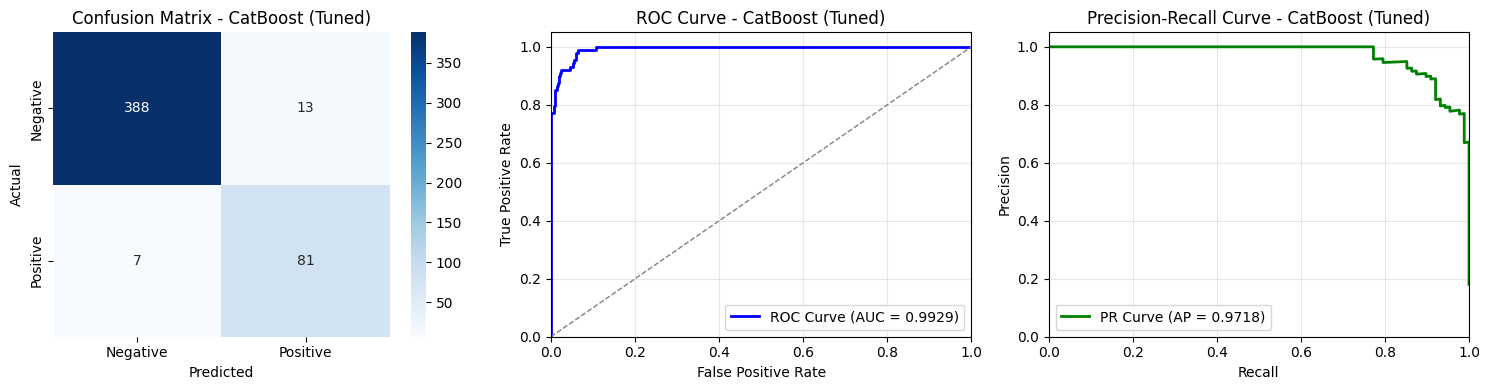

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_title('Confusion Matrix - CatBoost (Tuned)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - CatBoost (Tuned)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve - CatBoost (Tuned)')
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Simpan Model Terbaik

In [11]:
os.makedirs(model_path, exist_ok=True)

joblib.dump(final_model, f"{model_path}/catboost_pipeline.joblib")

fitted_preprocessor = final_model.named_steps['scaler']
joblib.dump(fitted_preprocessor, f"{model_path}/scaler.joblib")

cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='recall')

evaluation_results = {
    'best_params': best_params_clean,
    'cv_score': float(study.best_value),
    'test_metrics': {
        'accuracy': float(accuracy),
        'recall': float(recall_val),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'average_precision': float(avg_precision)
    },
    'cv_scores_per_fold': [float(x) for x in cv_scores],
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std()),
    'note': 'Pipeline-based CV (no data leakage)'
}

os.makedirs(f"{result_path}/CatBoost_Tuned", exist_ok=True)
with open(f"{result_path}/CatBoost_Tuned/CatBoost_tuned_evaluation.json", 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("=" * 60)
print("MODEL DAN HASIL BERHASIL DISIMPAN")
print("=" * 60)

MODEL DAN HASIL BERHASIL DISIMPAN
